<a href="https://colab.research.google.com/github/vitorfrois/ComplexNetworks/blob/main/random_graphs/ComplexNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1
Construir redes de 3 modelos aleatórios:
- Modelo BA
- Model ER
- Modelo WS

(usar mesmo tamanho de rede em vertices e arestas).

###2
Calcular várias medidas desta rede e plotar realizações deste modelo
usando PCA. Ver se é possivel encontrar alguma separação.



---
Import libraries to the project


In [ ]:
import networkx as nx
import math
import matplotlib.pyplot as plt
import statistics as stat
from collections import Counter
import random
import sklearn
import pandas as pd
import numpy as np

Define some variables to define randomic graph models where

Nodes $N = 1000$ \\
Links $L = 5000$ \\

In [ ]:
nodes = 1000
density = 0.01
links = int((density*nodes*(nodes-1))/2)
p = 2*links/(nodes*(nodes-1))
k = int(math.ceil(density*(nodes-1)))
m = int(k/2)
print(links, p, k, m)

4995 0.01 10 5


Function used to plot targeted and randomic attacks to analyze robustness

In [ ]:
def plot_attacks(G, attack_type):
  if attack_type != "targeted" and attack_type != "random":
    print("Possible attack types: 'targeted' and 'random'.")
    return

  C = G.copy()
  N = C.number_of_nodes()
  number_of_steps = 25
  M = N // number_of_steps
  random_attack_core_proportions = []
  num_nodes_removed = range(0, N, M)
  for nodes_removed in num_nodes_removed:
      # Measure the relative size of the network core
      core = next(nx.connected_components(C))
      core_proportion = len(core) / N
      random_attack_core_proportions.append(core_proportion)
      
      # If there are more than M nodes, select M nodes at random and remove them
      if C.number_of_nodes() > M:
        if attack_type == "random":
          nodes_to_remove = random.sample(list(C.nodes), M)
          C.remove_nodes_from(nodes_to_remove)
        elif attack_type == "targeted":
          nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
          nodes_to_remove = nodes_sorted_by_degree[:M]
          C.remove_nodes_from(nodes_to_remove)
  
  plt.title(attack_type)
  plt.xlabel('Number of nodes removed')
  plt.ylabel('Proportion of nodes in core')
  plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')

The `Graph()` class.
It has some functions which allows us to compute important network parameters.

In [ ]:
class Graph():
  def __init__(self, graph, name):
    self.G = graph
    self.name = name
    self.deg_list = [self.G.degree(n) for n in self.G.nodes()]
    self.nodes = nx.number_of_nodes(self.G)
    self.edges = nx.number_of_edges(self.G)
    self._density = nx.density(self.G)
    self._da_coeff = nx.degree_assortativity_coefficient(self.G)
    if(nx.is_connected(self.G)):
      self._spl_mean = nx.average_shortest_path_length(self.G)
    else:
      closeness_centr = nx.closeness_centrality(self.G)
      self._spl_mean = stat.mean(closeness_centr)
    nodes_clustering = nx.clustering(self.G)
    self._c_mean = stat.mean(nodes_clustering.values())
    self._c_stdev = stat.stdev(nodes_clustering.values())
    self._dg_mean = stat.mean(self.deg_list)
    self._dg_stdev = stat.stdev(self.deg_list)
    self.dg_median = stat.median(self.deg_list)
    betweenness = nx.betweenness_centrality(self.G)
    self.betweenness_sequence = list(betweenness.values())
    self._bt_mean = stat.mean(self.betweenness_sequence)
    self._bt_stdev = stat.stdev(self.betweenness_sequence)
    self.bt_median = stat.median(self.betweenness_sequence)

  def bgm(self):
    print(self.name) 
    print("Nodes:", self.nodes)
    print("Links:", self.edges)
    print("Density:", self._density)

  def swm(self):
    print(self.name) 
    print("Assortativity by degree:", self._da_coeff)
    print("Average shortest path lenght:", self._spl_mean)
    print("Clustering coefficient:", self._c_mean)

  def plot(self):
    nx.draw(self.G, node_size=2)

  def hist(self):
    degree_sequence = sorted([d for n, d in self.G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(f"Degree Histogram for {self.name} model")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    # plt.show()
    if(self.name == "Barabasi-Albert"):
      plt.xscale('log')
      plt.grid(True)
    plt.show()

    
  def centrality(self):
    #centrality distributions
    print("Mean degree:", self._dg_mean)
    print("Median degree:", self.dg_median)
    print("Mean betweenness:", self._bt_mean)
    print("Median betweenness:", self.bt_median)
    #plots
    degree_counts = Counter(self.deg_list)
    plt.ylabel("N of nodes")
    plt.xlabel("Betweenness")
    plt.hist(self.betweenness_sequence)
    # if(self.name == "Barabasi-Albert"):
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
  def robustness(self):
    #robustness
    plt.figure(1)
    plot_attacks(self.G, "random")
    plt.figure(2)
    plot_attacks(self.G, "targeted")
  
  def core(self):
    #tried to simplify the graph with a core decomposition
    n = nx.number_of_nodes(self.G)
    net = self.G
    k = 1
    nodes_after_dec = n #nodes after decomposition
    while(nodes_after_dec != 0):
      oldNet = net
      net = nx.k_core(net, k)
      k += 1
      nodes_after_dec = nx.number_of_nodes(net)
    pos = nx.spring_layout(oldNet)
    nx.draw_networkx_nodes(oldNet, pos, node_size=20)
    nx.draw_networkx_edges(oldNet, pos, alpha=0.2)

graph_list = []
for i in range(10):
  graph_list.append(Graph(nx.erdos_renyi_graph(nodes, p), "Erdos-Renyi"))
  graph_list.append(Graph(nx.watts_strogatz_graph(nodes, k, 0.5), "Watts-Strogatz"))
  graph_list.append(Graph(nx.barabasi_albert_graph(nodes, m), "Barabasi-Albert"))

ER = graph_list[0]
WS = graph_list[1]
BA = graph_list[2]

In [ ]:
d = {}

class_vars = vars(ER)
title = []
for i in class_vars:
  if i.startswith("_"):
    title.append(i)
d['name'] = title

def get_var(G):
  data = []
  class_vars = vars(G)
  for i in class_vars:
    if i.startswith("_"):
      data.append(class_vars[i])
  return data

i = 0
for graph in graph_list:
  d[f'{graph.name}-{i}'] = get_var(graph)
  i += 1

df = pd.DataFrame(d)
df = df.T
df, df.columns = df[1:], df.iloc[0]
num_data = df.values
df

name,_density,_da_coeff,_spl_mean,_c_mean,_c_stdev,_dg_mean,_dg_stdev,_bt_mean,_bt_stdev
Erdos-Renyi-0,0.009988,-0.016611,3.257852,0.01073,0.018888,9.978,3.06805,0.002262,0.001366
Watts-Strogatz-1,0.01001,-0.055186,3.381357,0.090224,0.065867,10.0,1.88774,0.002386,0.001029
Barabasi-Albert-2,0.00996,-0.048463,2.978382,0.038897,0.05526,9.95,10.345556,0.001982,0.007076
Erdos-Renyi-3,0.009906,0.009135,3.26811,0.009985,0.017343,9.896,3.244952,0.002273,0.001476
Watts-Strogatz-4,0.01001,-0.047317,3.381848,0.093511,0.062751,10.0,1.977855,0.002387,0.001069
Barabasi-Albert-5,0.00996,-0.057996,2.974486,0.042083,0.05449,9.95,10.288409,0.001978,0.006761
Erdos-Renyi-6,0.010122,-0.010722,3.241544,0.009471,0.017507,10.112,3.058564,0.002246,0.001314
Watts-Strogatz-7,0.01001,-0.042171,3.387399,0.096805,0.070739,10.0,1.958529,0.002392,0.001056
Barabasi-Albert-8,0.00996,-0.056819,2.987672,0.042985,0.059707,9.95,10.19772,0.001992,0.006475
Erdos-Renyi-9,0.009998,0.01881,3.257119,0.009212,0.016928,9.988,3.083726,0.002262,0.001367


In [ ]:
#pca
from sklearn.preprocessing import StandardScaler
x = df.loc[:, d['name']].values
x = StandardScaler().fit_transform(x)

Text(0.5, 1.0, 'Projection of graph data using PCA')

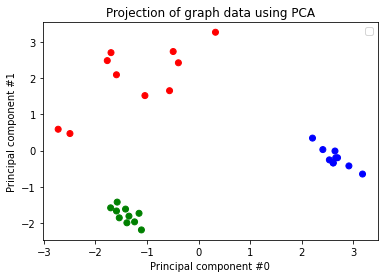

In [ ]:
from sklearn.decomposition import PCA
pca_graph = PCA(n_components=2)
pca = pca_graph.fit_transform(x)

colors = []
for graph in graph_list:
  name = graph.name
  c = 'w'
  if name.startswith('E'):
    c = 'r'
  elif name.startswith('W'):
    c = 'g'
  elif name.startswith('B'):
    c = 'b'
  colors.append(c)

plt.scatter(pca[:, 0], pca[:, 1], c=colors)
plt.legend()
plt.ylabel("Principal component #1")
plt.xlabel("Principal component #0")
plt.title("Projection of graph data using PCA")

### Basic Graph Measures
Some very basic definitions about the randomic graphs.

In [ ]:
#basic graph measures
ER.bgm()
WS.bgm()
BA.bgm()

Erdos-Renyi
Nodes: 1000
Links: 4989
Density: 0.009987987987987989
Watts-Strogatz
Nodes: 1000
Links: 5000
Density: 0.01001001001001001
Barabasi-Albert
Nodes: 1000
Links: 4975
Density: 0.00995995995995996


We can see the number of nodes $ = N$ and the number of links is around $5000$. Thus, it is possible to calculate density, which is close to $0.010$ in all three graphs and a good approximation to density in Real World nets.

---

### Small Worlds Features
Analysis on assortativity, average shortest path lenght and clustering.


In [ ]:
#small worlds measures
ER.swm()
WS.swm()
BA.swm()

Erdos-Renyi
Assortativity by degree: -0.016611432526063254
Average shortest path lenght: 3.2578518518518518
Clustering coefficient: 0.010729584255277484
Watts-Strogatz
Assortativity by degree: -0.05518621187339756
Average shortest path lenght: 3.3813573573573574
Clustering coefficient: 0.09022361037655155
Barabasi-Albert
Assortativity by degree: -0.04846290490801611
Average shortest path lenght: 2.9783823823823825
Clustering coefficient: 0.03889675238353871


#### Assortativity
Is the property that measures the connection about nodes of the same type. The assortativity in ER model is higher than WS and BA model, what means the first model is less heterogenic than the others. Clearly the BA model is the most diverse one.

#### Average shortest path lenght (ASPL)
A strong small world feature is the ASPL. The smaller, the most connected the network is. So, we can conclude that between the three models, BA is the one with most relevant links. In a real network, shortest paths are very common: you can reach any site with a bunch of clicks or reach any person by know people.

#### Clustering coefficient
It is the ratio $\frac{totalTriangles}{maxTriangles}$. Clustering is also important because of it's relevance in a social network, for example. A friend of yours is also your friend. According to the coefficient calculated we can conclude WS model is the one with better clustering coefficient, which makes a lot of sense, since the random graph is generated after a cluster matrix.

---

### Histograms
Sometimes, it is better to visualize data in graphs instead of printing features. The histograms show graphs from a $count\times degree$ perspective. 


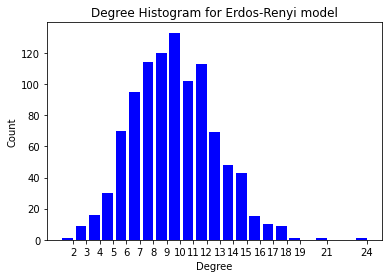

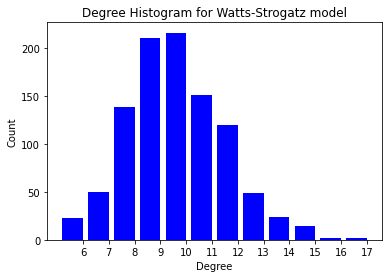

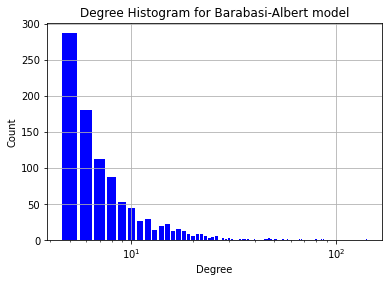

In [ ]:
ER.hist()
WS.hist()
BA.hist()

The histograms show that the first two models have a well equilibrated distribution, where most of the nodes correspond to the mean, while the last one has a heavy-tailed distribution that indicated presence of hubs.

---

### Centrality
We can measure centrality in a bunch of different ways. The betweenness represents how often its necessary to go through some node to get shortest path along the network.

Mean degree: 9.978
Median degree: 10.0
Mean betweenness: 0.0022623766050619758
Median betweenness: 0.001996268999504204


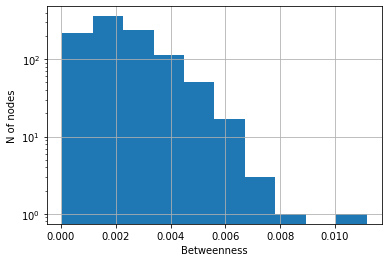

Mean degree: 10
Median degree: 10.0
Mean betweenness: 0.0023861296165905385
Median betweenness: 0.002243631697625379


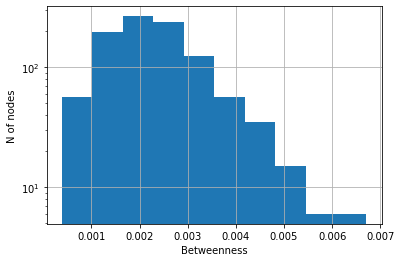

Mean degree: 9.95
Median degree: 7.0
Mean betweenness: 0.001982347076535453
Median betweenness: 0.0005114093927146627


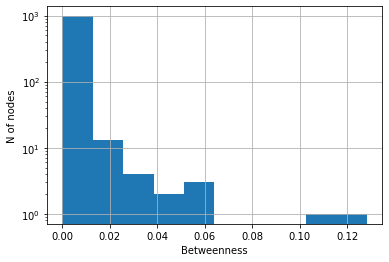

In [ ]:
ER.centrality()
WS.centrality()
BA.centrality()

Similar as before, the first two models have a very well distributed histogram, corresponding to the values shown in mean and median betweenness.
But in the Barabasi-Albert model, a heavy tailed distribution appears again, this time indicating that a small set of nodes in the graph have a very high betweenness, reinforcing the presence of hubs in the net.

---

### Plots
Finally, we can plot the graphs trying to visualize better each model.
(here I tried to plot a core decomposition but it didn't work as intended. Although it is still possible to see peripherical nodes and some links).

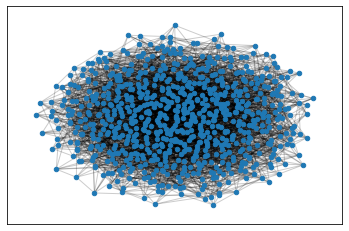

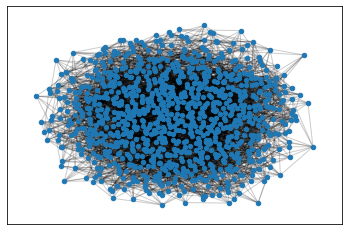

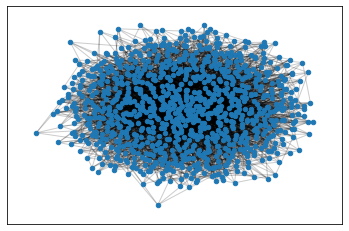

In [ ]:
plt.figure(1)
ER.core()
plt.figure(2)
WS.core()
plt.figure(3)
BA.core()